In [19]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# If working locally :
data_path = 'data/'

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader & TextBlob

In [3]:
sid = SentimentIntensityAnalyzer()
text = "I am really extremely sad"
scores = sid.polarity_scores(text)
print(TextBlob(text).sentiment.polarity)
print(scores)

-0.5
{'neg': 0.479, 'neu': 0.521, 'pos': 0.0, 'compound': -0.5678}


## Extract only quotes from bz file (2012)

In [4]:
quotes = []
index =0
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    for ins in tqdm(s_file): 
        quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])


2467465it [02:06, 24493.46it/s]

KeyboardInterrupt: 

In [5]:
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]



In [6]:
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]


In [7]:
df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

2467465it [02:20, 24493.46it/s]

In [14]:
df['Speaker'].value_counts()[:23]

None                      138611
mitt romney                26926
president obama            13580
president barack obama     13080
barack obama                5870
rick santorum               4911
newt gingrich               4220
paul ryan                   3957
ron paul                    2493
hillary clinton             2401
david cameron               2395
chris christie              1995
joe biden                   1735
thomas more                 1666
tiger woods                 1665
john boehner                1575
scott walker                1562
vladimir putin              1508
trayvon martin              1500
whitney houston             1492
manmohan singh              1489
justin bieber               1480
tim tebow                   1406
Name: Speaker, dtype: int64

In [15]:
def AnalyseSpeaker(speaker):
    speaker_df = df.loc[df['Speaker'].str.contains(speaker, case=False)]
    speaker_df['TextBlob'] = speaker_df.apply(lambda row: TextBlob(row.Quote).sentiment.polarity,  axis = 1)
    speaker_df['Vader_pos'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['pos'],  axis = 1)
    speaker_df['Vader_neg'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neg'],  axis = 1)
    speaker_df['Vader_com'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['compound'],  axis = 1)
    speaker_df['Vader_neu'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neu'],  axis = 1)
    speaker_df['mean_vader_blob'] = speaker_df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    speaker_df = speaker_df.reset_index()
    speaker_df['Date'] = pd.to_datetime(speaker_df['Date'], errors='coerce')

    speaker_df.set_index('Date', inplace=True)
    return speaker_df


In [17]:
Obama_df = AnalyseSpeaker('obama')
mitt_df = AnalyseSpeaker('mitt romney')
hill_df = AnalyseSpeaker('hillary clinton')

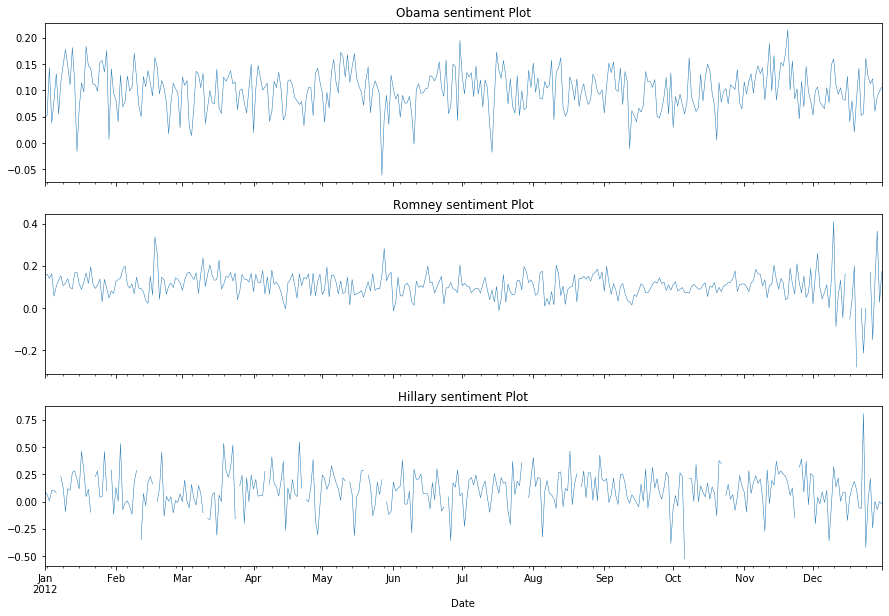

In [30]:
freq = 'D'
Obama_day_mean = Obama_df['mean_vader_blob'].resample(freq).mean()
Romney_day_mean = mitt_df['mean_vader_blob'].resample(freq).mean()
Hillary_day_mean = hill_df['mean_vader_blob'].resample(freq).mean()

fig, axs = plt.subplots(3,sharex=True,figsize=(15,10))
axs[0].title.set_text('Obama sentiment Plot')
axs[1].title.set_text('Romney sentiment Plot')
axs[2].title.set_text('Hillary sentiment Plot')

Obama_day_mean.plot(linewidth=0.5,ax = axs[0])
Romney_day_mean.plot(linewidth=0.5,ax=axs[1])
Hillary_day_mean.plot(linewidth=0.5,ax=axs[2])


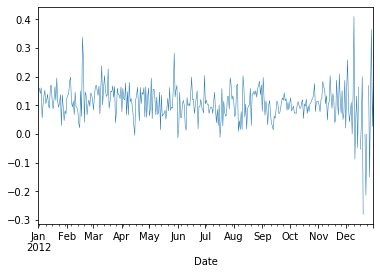

In [28]:
Romney_day_mean = mitt_df['mean_vader_blob'].resample('D').mean()
Romney_day_mean.plot(linewidth=0.5)


In [9]:
sentiments = []
neg = []
pos = []
neu = []
com = []
min_blob_vader_pos = []
max_blob_vader_pos= []
mean_scores = []
blobscores = []
for i in tqdm(quotes):
    scores = sid.polarity_scores(i)
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    com.append(scores['compound'])
    # adjust blobscore btw 0 and 1
    blobscore = TextBlob(i).sentiment.polarity
    blobscores.append(blobscore)
    if blobscore>0 and scores['pos']> 0:
        max_blob_vader_pos.append(max(scores['pos'],blobscore ))
        mean_scores.append(np.mean([scores['pos'],blobscore]))

    if blobscore<0 and scores['neg'] > 0:
        min_blob_vader_pos.append(max(scores['neg'],-blobscore ))
        mean_scores.append(np.mean([-scores['neg'],blobscore]))
    


  1%|▏         | 20792/1446436 [00:09<09:35, 2479.34it/s]
1445753it [01:00, 32839.28it/s][00:09<09:17, 2558.30it/s]
  4%|▍         | 64256/1446436 [00:27<09:28, 2431.16it/s]


  9%|▉         | 128033/1446436 [00:55<09:02, 2430.22it/s]


 13%|█▎        | 193290/1446436 [01:22<08:42, 2399.63it/s]


 18%|█▊        | 258239/1446436 [01:49<08:10, 2420.95it/s]


 22%|██▏       | 323211/1446436 [02:16<08:07, 2302.18it/s]


 27%|██▋       | 388519/1446436 [02:43<07:12, 2446.23it/s]


 31%|███▏      | 453736/1446436 [03:10<06:54, 2392.59it/s]


 36%|███▌      | 518642/1446436 [03:37<06:21, 2435.15it/s]


 40%|████      | 583828/1446436 [04:04<05:50, 2459.74it/s]


 45%|████▍     | 648081/1446436 [04:32<05:40, 2346.53it/s]


 49%|████▉     | 712745/1446436 [04:59<05:22, 2271.69it/s]


 54%|█████▍    | 777603/1446436 [05:26<04:50, 2304.02it/s]


 58%|█████▊    | 842086/1446436 [05:53<04:16, 2357.30it/s]


 63%|██████▎   | 907007/1446436 [06:20<03:42, 2419.02it/s]


 67%|██████▋   | 971323/1446436 [06:47<03:19, 2384.48it/s]


 72%|███████▏  | 1035357/1446436 [07:14<02:52, 2378.49it/s]


 76%|███████▌  | 1098556/1446436 [07:41<02:30, 2306.56it/s]


 80%|████████  | 1161067/1446436 [08:08<02:04, 2291.94it/s]


 85%|████████▍ | 1223360/1446436 [08:35<01:34, 2363.17it/s]


 89%|████████▉ | 1285686/1446436 [09:01<01:10, 2286.65it/s]


 93%|█████████▎| 1351966/1446436 [09:28<00:39, 2391.50it/s]


 98%|█████████▊| 1413976/1446436 [09:55<00:14, 2304.59it/s]


100%|██████████| 1446436/1446436 [10:09<00:00, 2372.74it/s]


In [36]:
import seaborn as sns

In [12]:
len(quotes)

1446436

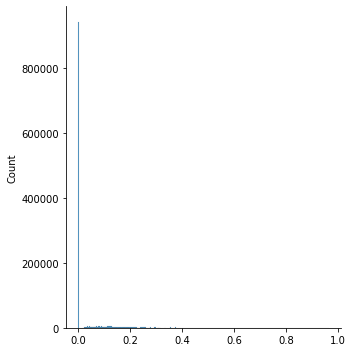

In [13]:

sns.displot(neg)

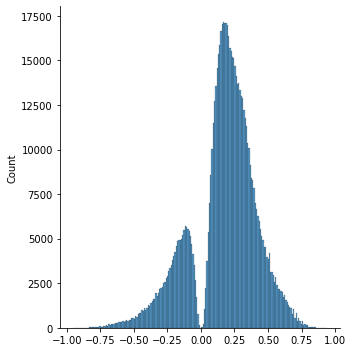

In [14]:

sns.displot(mean_scores, bins = 200)


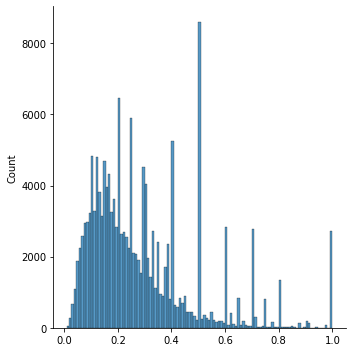

In [15]:
sns.displot(min_blob_vader_pos)

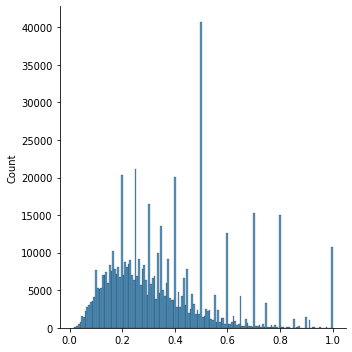

In [16]:
sns.displot(max_blob_vader_pos)

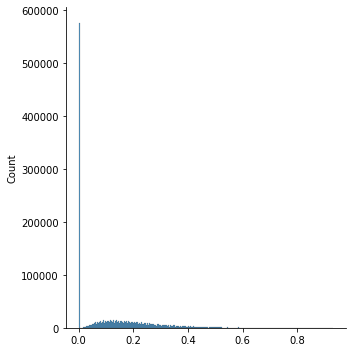

In [17]:
sns.displot(pos)

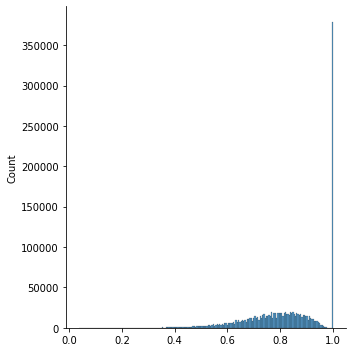

In [18]:
sns.displot(neu)

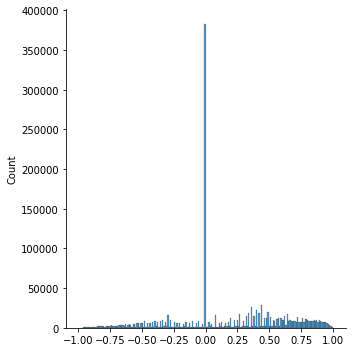

In [19]:
sns.displot(com)

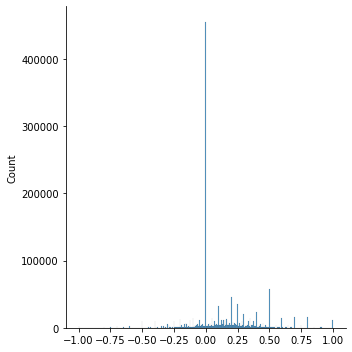

In [22]:
sns.displot(blobscores)

In [9]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
print(sentiment_analysis("I love this!"))

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
No module named 'tensorflow.python.keras.engine.keras_tensor'